In [2]:
# All necessary imports
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.mlls import VariationalELBO

In [3]:
# This block of code will make everything run on the same seed, so the results stay the same every runtime.

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If you're using GPU

# Ensure deterministic behavior for PyTorch (may slow down training slightly)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seed set to: {seed}")

Seed set to: 42


In [4]:
# Load the CSV file
file_name = 'datasets/autonomous_arena.csv'  # Replace with the correct file path if needed
data = pd.read_csv(file_name)

# Check for missing data
missing_data = data.isnull().sum().sum()

# Report the shape of the dataset
data_shape = data.shape

# Output results
print(f"Shape of the dataset: {data_shape}")
print(f"Number of missing values: {missing_data}")

Shape of the dataset: (14526, 449)
Number of missing values: 0


In [4]:
# Separate input features (X) and target (y)
X = data.iloc[:, :-1].values  # All columns except the last one
y = data.iloc[:, -1].values   # The last column

# Apply StandardScaler to the input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Output results for verification
print("Input features (X) have been scaled.")
print(f"Shape of X: {X_scaled.shape}")
print(f"Target (y) shape: {y.shape}")

Input features (X) have been scaled.
Shape of X: (14526, 448)
Target (y) shape: (14526,)


In [5]:
# Convert target column data type from string to numerical

# Ensure the target column is a string (if not already)
y = y.astype(str)

# Ensure the target column is in uppercase to avoid case issues
y_upper = pd.Series(y).str.upper()

# Map the string labels ('L', 'R', 'F', 'S') to numeric values (0, 1, 2, 3)
label_mapping = {'L': 0, 'R': 1, 'F': 2, 'S': 3}
y_numeric = y_upper.map(label_mapping)

# Verify the conversion by checking unique values
print(f"Unique values in the target column after conversion: {y_numeric.unique()}")

# Replace y with the numeric target values
y = y_numeric


Unique values in the target column after conversion: [2 1 0 3]


In [6]:
# Split data into training and temporary (30% for testing + validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y_numeric, test_size=0.3, random_state=42
)

# Split temporary data into validation and test sets (50% each of the 30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Check the shapes to ensure alignment
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10168, 448), y_train shape: (10168,)
X_val shape: (2179, 448), y_val shape: (2179,)
X_test shape: (2179, 448), y_test shape: (2179,)


In [7]:
# This block of code implements a function to display pretty confusion matrices

def plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix"):
    """
    Plot a confusion matrix with better styling.

    Args:
        conf_matrix (array-like): Confusion matrix (e.g., from sklearn.metrics.confusion_matrix).
        class_names (list): List of class names (in order).
        title (str): Title of the confusion matrix plot.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

In [8]:
# Define the Simple NN, which will serve as the baseline.
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        # Define layers as per the architecture
        self.fc1 = nn.Linear(input_size, 128)  # Input layer
        self.fc2 = nn.Linear(128, 64)         # Hidden layer
        self.fc3 = nn.Linear(64, 32)          # Hidden layer
        self.fc4 = nn.Linear(32, 4)           # Output layer for 4 classes

    def forward(self, x):
        # Define forward pass
        x = F.relu(self.fc1(x))  # Activation for first layer
        x = F.relu(self.fc2(x))  # Activation for second layer
        x = F.relu(self.fc3(x))  # Activation for third layer
        x = self.fc4(x)          # Output layer (no activation for logits)
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of features in input data
model = SimpleNN(input_size)

# Print model summary
print(model)

SimpleNN(
  (fc1): Linear(in_features=448, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


In [9]:
# This block of code trains the SimpleNN and saves the weights for later use.

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer

# Training loop
num_epochs = 20
model.train()  # Set model to training mode

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        X_batch, y_batch = batch

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Save the model weights
torch.save(model.state_dict(), "simple_nn_weights.pth")
print("Model weights saved as 'simple_nn_weights.pth'")

Epoch 1/20, Loss: 241.5445, Accuracy: 0.7554
Epoch 2/20, Loss: 145.4655, Accuracy: 0.8537
Epoch 3/20, Loss: 118.6464, Accuracy: 0.8736
Epoch 4/20, Loss: 106.7611, Accuracy: 0.8856
Epoch 5/20, Loss: 97.2259, Accuracy: 0.8951
Epoch 6/20, Loss: 90.3268, Accuracy: 0.9022
Epoch 7/20, Loss: 85.2159, Accuracy: 0.9088
Epoch 8/20, Loss: 80.7453, Accuracy: 0.9117
Epoch 9/20, Loss: 76.2103, Accuracy: 0.9171
Epoch 10/20, Loss: 69.6547, Accuracy: 0.9247
Epoch 11/20, Loss: 67.5605, Accuracy: 0.9276
Epoch 12/20, Loss: 64.1611, Accuracy: 0.9317
Epoch 13/20, Loss: 59.1959, Accuracy: 0.9371
Epoch 14/20, Loss: 57.5059, Accuracy: 0.9366
Epoch 15/20, Loss: 53.3292, Accuracy: 0.9425
Epoch 16/20, Loss: 54.9842, Accuracy: 0.9412
Epoch 17/20, Loss: 48.9580, Accuracy: 0.9459
Epoch 18/20, Loss: 48.2736, Accuracy: 0.9481
Epoch 19/20, Loss: 47.0981, Accuracy: 0.9508
Epoch 20/20, Loss: 47.5589, Accuracy: 0.9497
Model weights saved as 'simple_nn_weights.pth'


Accuracy: 0.8779


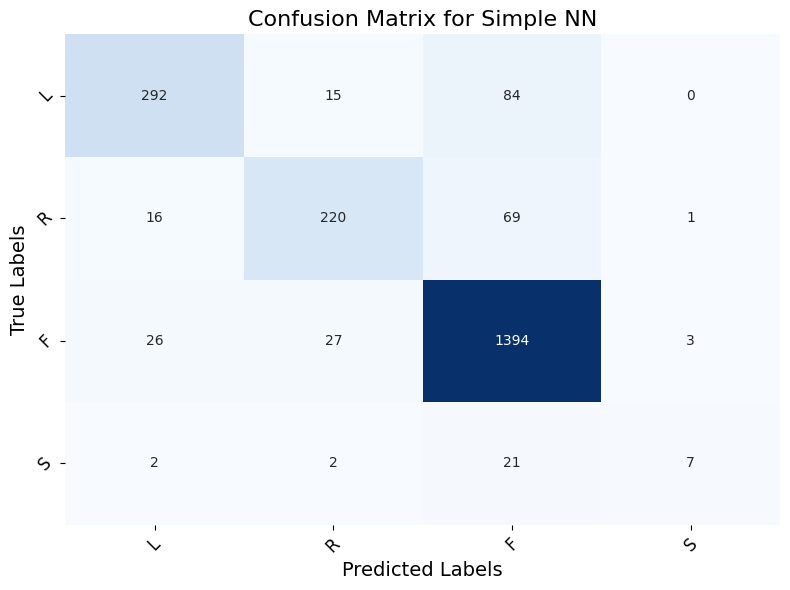

Number of predictions taking longer than 125ms: 0
Average time per prediction (ms): 0.1126


array([0.24999459, 0.24181496, 0.20540871, ..., 0.20386672, 0.09093166,
       0.24976292])

In [10]:
# Prepare test dataset and loader
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for real-time evaluation

# Set model to evaluation mode
model.eval()

# Initialize lists for results
all_predictions = []
all_true_labels = []
all_variance_proxies = []  # Variance proxy for uncertainty
prediction_times = []      # To store inference times

# Test the model
with torch.no_grad():
    for batch in test_loader:
        X_batch, y_batch = batch

        # Start timing
        start_time = time.time()

        # Forward pass
        logits = model(X_batch)

        # Apply softmax to get probabilities
        probabilities = F.softmax(logits, dim=1)

        # Get predicted class (index of max probability)
        predicted_class = probabilities.argmax(dim=1).item()

        # Compute variance proxy (variance of softmax probabilities)
        variance_proxy = probabilities.var(dim=1).item()

        # End timing
        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
        prediction_times.append(inference_time)

        # Store results
        all_predictions.append(predicted_class)
        all_true_labels.append(y_batch.item())
        all_variance_proxies.append(variance_proxy)

# Calculate metrics
accuracy_NN = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
times_exceeding_125ms_NN = sum(1 for t in prediction_times if t > 125)
average_time_per_prediction_NN = np.mean(prediction_times)

# Output results
print(f"Accuracy: {accuracy_NN:.4f}")
class_names = ['L', 'R', 'F', 'S']
plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix for Simple NN")
print(f"Number of predictions taking longer than 125ms: {times_exceeding_125ms_NN}")
print(f"Average time per prediction (ms): {average_time_per_prediction_NN:.4f}")

# Bundle variance proxies for later use
uncertainties_simpleNN = np.array(all_variance_proxies)

# Return uncertainties for later use
uncertainties_simpleNN

Accuracy with MC Dropout: 0.8779


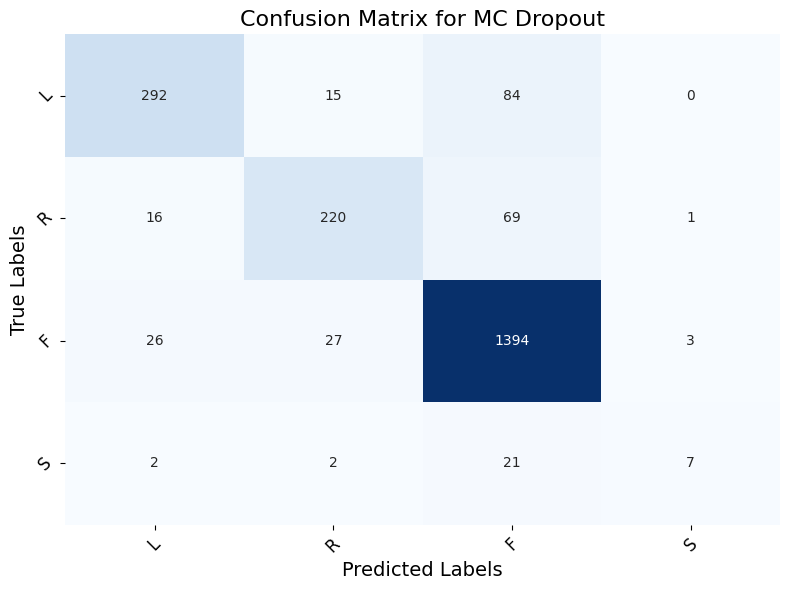

Number of predictions taking longer than 125ms: 0
Average time per prediction with MC Dropout (ms): 3.2294


array([4.35207426e-14, 3.46944695e-18, 1.42993256e-14, ...,
       4.37427872e-14, 1.16573418e-15, 1.07469596e-13], dtype=float32)

In [11]:
# Function to enable dropout during inference
def enable_dropout(model):
    for module in model.modules():
        if module.__class__.__name__.startswith('Dropout'):
            module.train()

# Enable dropout layers for MC Dropout
enable_dropout(model)

# Initialize lists for results
all_predictions = []
all_true_labels = []
all_variances = []  # Variance across stochastic forward passes for uncertainty
prediction_times = []  # To store inference times

# Set number of stochastic passes
n_passes = 50

# Test the model with MC Dropout
with torch.no_grad():
    for batch in test_loader:
        X_batch, y_batch = batch

        # Start timing
        start_time = time.time()

        # Collect predictions from multiple forward passes
        stochastic_outputs = []
        for _ in range(n_passes):
            logits = model(X_batch)  # Forward pass
            probabilities = F.softmax(logits, dim=1)  # Convert to probabilities
            stochastic_outputs.append(probabilities.cpu().numpy())

        # Convert list of predictions to a NumPy array
        stochastic_outputs = np.array(stochastic_outputs)  # Shape: (n_passes, batch_size, num_classes)

        # Compute the mean prediction (for final class prediction)
        mean_prediction = stochastic_outputs.mean(axis=0)  # Shape: (batch_size, num_classes)
        predicted_class = mean_prediction.argmax(axis=1)[0]  # Predicted class

        # Compute variance across the stochastic passes (for uncertainty)
        variance = stochastic_outputs.var(axis=0).mean()  # Mean variance as uncertainty proxy

        # End timing
        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
        prediction_times.append(inference_time)

        # Store results
        all_predictions.append(predicted_class)
        all_true_labels.append(y_batch.item())
        all_variances.append(variance)

# Calculate metrics
accuracy_MC = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
times_exceeding_125ms_MC = sum(1 for t in prediction_times if t > 125)
average_time_per_prediction_MC = np.mean(prediction_times)

# Output results
print(f"Accuracy with MC Dropout: {accuracy_MC:.4f}")
plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix for MC Dropout")
print(f"Number of predictions taking longer than 125ms: {times_exceeding_125ms_MC}")
print(f"Average time per prediction with MC Dropout (ms): {average_time_per_prediction_MC:.4f}")

# Bundle variances for later use
uncertainties_mc_dropout = np.array(all_variances)

# Return uncertainties for later use
uncertainties_mc_dropout


In [12]:
# Directory to save ensemble weights
ensemble_dir = "bagging_ensemble_weights"
os.makedirs(ensemble_dir, exist_ok=True)

# Define ensemble parameters
n_models = 5  # Number of models in the ensemble

# Initialize ensemble
ensemble = []

for i in range(n_models):
    print(f"Training model {i + 1}/{n_models}...")

    # Create a new instance of the model
    model = SimpleNN(input_size)

    # Use the same optimizer and criterion as before
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Create a bootstrapped dataset
    bootstrap_X, bootstrap_y = resample(X_train, y_train)
    bootstrap_X_tensor = torch.tensor(bootstrap_X, dtype=torch.float32)
    bootstrap_y_tensor = torch.tensor(bootstrap_y.values, dtype=torch.long)
    bootstrap_dataset = TensorDataset(bootstrap_X_tensor, bootstrap_y_tensor)
    bootstrap_loader = DataLoader(bootstrap_dataset, batch_size=32, shuffle=True)

    # Train the model
    model.train()
    num_epochs = 20
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in bootstrap_loader:
            X_batch, y_batch = batch

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            epoch_loss += loss.item()

        print(f"Model {i + 1}, Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Save the model's weights
    model_path = os.path.join(ensemble_dir, f"model_{i + 1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Saved model {i + 1} weights to {model_path}.")

    # Add the trained model to the ensemble
    ensemble.append(model)

print(f"All {n_models} models in the ensemble have been trained and saved.")

Training model 1/5...
Model 1, Epoch 1/20, Loss: 238.3073
Model 1, Epoch 2/20, Loss: 137.7648
Model 1, Epoch 3/20, Loss: 109.7709
Model 1, Epoch 4/20, Loss: 91.2985
Model 1, Epoch 5/20, Loss: 81.5494
Model 1, Epoch 6/20, Loss: 68.8667
Model 1, Epoch 7/20, Loss: 63.4351
Model 1, Epoch 8/20, Loss: 56.7847
Model 1, Epoch 9/20, Loss: 54.6208
Model 1, Epoch 10/20, Loss: 51.5076
Model 1, Epoch 11/20, Loss: 47.4164
Model 1, Epoch 12/20, Loss: 45.8367
Model 1, Epoch 13/20, Loss: 43.0780
Model 1, Epoch 14/20, Loss: 39.9842
Model 1, Epoch 15/20, Loss: 37.7938
Model 1, Epoch 16/20, Loss: 35.1805
Model 1, Epoch 17/20, Loss: 41.8981
Model 1, Epoch 18/20, Loss: 34.2046
Model 1, Epoch 19/20, Loss: 31.4155
Model 1, Epoch 20/20, Loss: 32.4243
Saved model 1 weights to bagging_ensemble_weights\model_1.pth.
Training model 2/5...
Model 2, Epoch 1/20, Loss: 241.3392
Model 2, Epoch 2/20, Loss: 138.9776
Model 2, Epoch 3/20, Loss: 112.2277
Model 2, Epoch 4/20, Loss: 94.7828
Model 2, Epoch 5/20, Loss: 85.4565
M

Accuracy with Bagging Ensemble: 0.8935
Number of predictions taking longer than 125ms: 0
Average time per prediction with Bagging Ensemble (ms): 0.3804


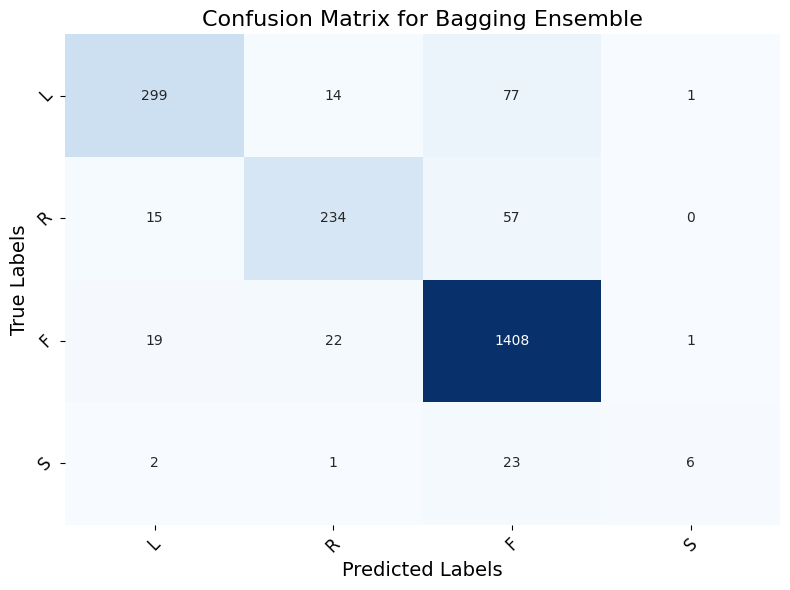

array([2.4266306e-10, 8.8483881e-05, 1.9859330e-04, ..., 3.5393543e-07,
       1.3550164e-03, 3.2026748e-09], dtype=float32)

In [13]:
# Initialize lists for results
all_predictions = []
all_true_labels = []
all_variances = []  # Variance across ensemble predictions for uncertainty
prediction_times = []  # To store inference times

# Set the ensemble models to evaluation mode
for model in ensemble:
    model.eval()

# Test the ensemble
with torch.no_grad():
    for batch in test_loader:
        X_batch, y_batch = batch

        # Start timing
        start_time = time.time()

        # Collect predictions from all models in the ensemble
        ensemble_outputs = []
        for model in ensemble:
            logits = model(X_batch)
            probabilities = F.softmax(logits, dim=1)  # Convert logits to probabilities
            ensemble_outputs.append(probabilities.cpu().numpy())

        # Convert list of predictions to a NumPy array
        ensemble_outputs = np.array(ensemble_outputs)  # Shape: (n_models, batch_size, num_classes)

        # Compute mean prediction (for final class prediction)
        mean_prediction = ensemble_outputs.mean(axis=0)  # Shape: (batch_size, num_classes)
        predicted_class = mean_prediction.argmax(axis=1)[0]  # Predicted class

        # Compute variance across ensemble predictions (for uncertainty)
        variance = ensemble_outputs.var(axis=0).mean()  # Mean variance as uncertainty proxy

        # End timing
        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
        prediction_times.append(inference_time)

        # Store results
        all_predictions.append(predicted_class)
        all_true_labels.append(y_batch.item())
        all_variances.append(variance)

# Calculate metrics
accuracy_Bag = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
times_exceeding_125ms_Bag = sum(1 for t in prediction_times if t > 125)
average_time_per_prediction_Bag = np.mean(prediction_times)

# Output results
print(f"Accuracy with Bagging Ensemble: {accuracy_Bag:.4f}")
print(f"Number of predictions taking longer than 125ms: {times_exceeding_125ms_Bag}")
print(f"Average time per prediction with Bagging Ensemble (ms): {average_time_per_prediction_Bag:.4f}")

# Pretty confusion matrix
plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix for Bagging Ensemble")

# Bundle variances for later use
uncertainties_bagging = np.array(all_variances)

# Return uncertainties for later use
uncertainties_bagging

In [14]:
# code to set up and train SGP here
# Prepare data
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(y_train.values, dtype=torch.float32)

# Define the Sparse Gaussian Process model
class SparseGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(SparseGPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Number of inducing points
num_inducing = 100

# Initialize inducing points (random subset of training data)
inducing_points = train_x[:num_inducing]

# Initialize model and likelihood
model = SparseGPModel(inducing_points)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Define the variational ELBO loss
mll = VariationalELBO(likelihood, model, num_data=train_x.size(0))

# Set up optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

# Training loop
model.train()
likelihood.train()
num_epochs = 20
batch_size = 128

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Training Sparse Gaussian Process...")
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

torch.save(model.state_dict(), "sparse_gp_weights.pth")
print("Sparse GP weights saved as 'sparse_gp_weights.pth'")

print("Training complete.")

Training Sparse Gaussian Process...
Epoch 1/20, Loss: 188.4298
Epoch 2/20, Loss: 126.4811
Epoch 3/20, Loss: 110.3811
Epoch 4/20, Loss: 102.9374
Epoch 5/20, Loss: 97.3536
Epoch 6/20, Loss: 92.3569
Epoch 7/20, Loss: 87.5997
Epoch 8/20, Loss: 83.4597
Epoch 9/20, Loss: 80.2558
Epoch 10/20, Loss: 77.7506
Epoch 11/20, Loss: 75.8973
Epoch 12/20, Loss: 74.4928
Epoch 13/20, Loss: 73.7188
Epoch 14/20, Loss: 72.9824
Epoch 15/20, Loss: 72.2675
Epoch 16/20, Loss: 72.2267
Epoch 17/20, Loss: 71.9893
Epoch 18/20, Loss: 71.5301
Epoch 19/20, Loss: 71.3156
Epoch 20/20, Loss: 71.2376
Sparse GP weights saved as 'sparse_gp_weights.pth'
Training complete.


Testing Sparse Gaussian Process...
Accuracy with Sparse Gaussian Process: 0.7265
Number of predictions taking longer than 125ms: 0
Average time per prediction with SGP (ms): 1.6626


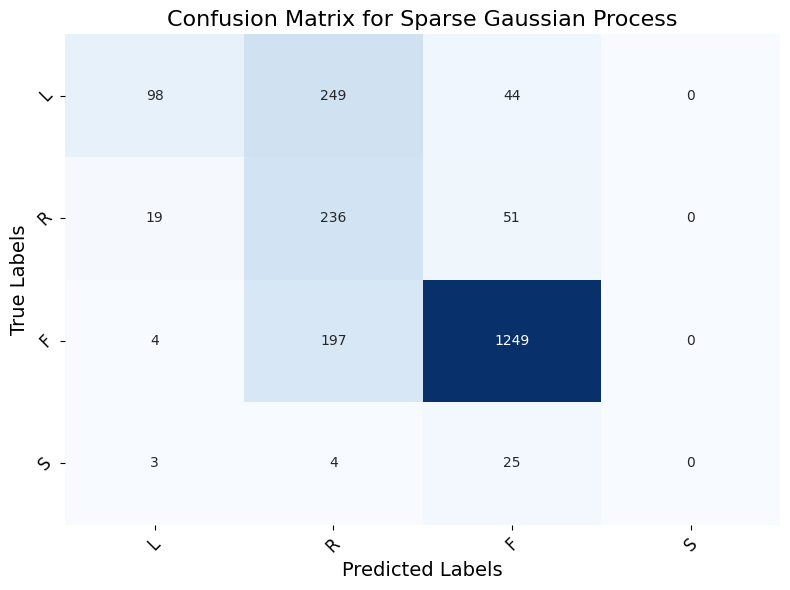

array([0.02173641, 0.05720087, 0.00840707, ..., 0.05198211, 0.0025904 ,
       0.02239167])

In [15]:
# Prepare test data
test_x = torch.tensor(X_test, dtype=torch.float32)
test_y = torch.tensor(y_test.values, dtype=torch.float32)

# Set model to evaluation mode
model.eval()
likelihood.eval()

# Initialize lists for results
all_predictions = []
all_true_labels = []
all_variances = []  # Predictive variance (uncertainty)
prediction_times = []  # Prediction times

# Test the model
print("Testing Sparse Gaussian Process...")
with torch.no_grad():
    for x, y in zip(test_x, test_y):
        x = x.unsqueeze(0)  # Add batch dimension for single-point prediction

        # Start timing
        start_time = time.time()

        # Get predictions
        predictive_dist = model(x)
        mean_prediction = predictive_dist.mean.item()
        variance = predictive_dist.variance.item()

        # End timing
        end_time = time.time()
        inference_time = (end_time - start_time) * 1000  # Convert to milliseconds
        prediction_times.append(inference_time)

        # Convert mean prediction to class (for classification)
        predicted_class = round(mean_prediction)  # Assuming regression outputs; adapt if classification

        # Store results
        all_predictions.append(predicted_class)
        all_true_labels.append(y.item())
        all_variances.append(variance)

# Calculate metrics
accuracy_SGP = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
times_exceeding_125ms_SGP = sum(1 for t in prediction_times if t > 125)
average_time_per_prediction_SGP = sum(prediction_times) / len(prediction_times)

# Output results
print(f"Accuracy with Sparse Gaussian Process: {accuracy_SGP:.4f}")
print(f"Number of predictions taking longer than 125ms: {times_exceeding_125ms_SGP}")
print(f"Average time per prediction with SGP (ms): {average_time_per_prediction_SGP:.4f}")

# Pretty confusion matrix
class_names = ['L', 'R', 'F', 'S']  # Replace with actual class labels
plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix for Sparse Gaussian Process")

# Return uncertainties for later use
uncertainties_sgp = np.array(all_variances)
uncertainties_sgp

Testing Combination Model...
Input 1:
  MC Dropout Uncertainty: 0.000000, Weight: 0.342850
  Bagging Ensemble Uncertainty: 0.000000, Weight: 0.342850
  Sparse GP Uncertainty: 0.021736, Weight: 0.314300


c:\Users\mattr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Accuracy with Combination Model: 0.8862
Number of predictions taking longer than 125ms: 0
Average time per prediction with Combination Model (ms): 5.5702


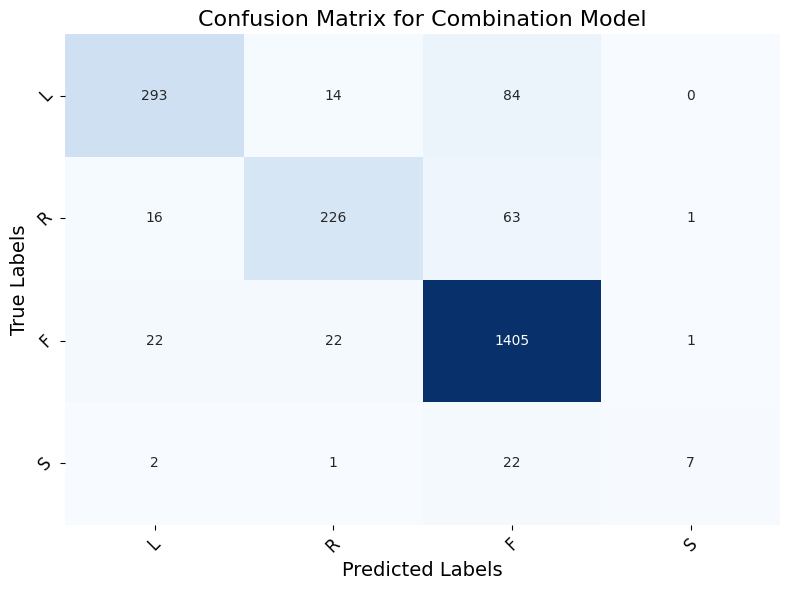

Weight proportions saved for each model.


In [16]:
# This block of code forms and tests the combination model.

# Reload MC Dropout model
model_mc_dropout = SimpleNN(input_size)  # Same architecture as before
model_mc_dropout.load_state_dict(torch.load("simple_nn_weights.pth", weights_only=True))  # Reload saved weights
model_mc_dropout.eval()  # Set to evaluation mode
enable_dropout(model_mc_dropout)  # Enable dropout for stochastic predictions

# Reload Bagging Ensemble
bagging_ensemble = []
for i in range(1, n_models + 1):
    bagging_model = SimpleNN(input_size)
    bagging_model.load_state_dict(torch.load(f"bagging_ensemble_weights/model_{i}.pth", weights_only=True))
    bagging_model.eval()
    bagging_ensemble.append(bagging_model)

# Reload Sparse GP
sparse_gp = SparseGPModel(inducing_points=torch.tensor(X_train[:num_inducing], dtype=torch.float32))
sparse_gp.load_state_dict(torch.load("sparse_gp_weights.pth", weights_only=True))
sparse_gp.eval()

# Initialize test results
all_predictions = []
all_true_labels = []
all_combination_uncertainties = []  # Final uncertainty (entropy)
prediction_times = []  # Time for each combined prediction
model_weights = []  # Stores weight proportions for each model

# Test the combination model
print("Testing Combination Model...")
with torch.no_grad():
    for idx, (x, y) in enumerate(zip(torch.tensor(X_test, dtype=torch.float32), y_test)):
        x = x.unsqueeze(0)  # Add batch dimension for single input

        # Start timing
        start_time = time.time()

        # Step 1: MC Dropout Prediction
        mc_dropout_outputs = []
        for _ in range(n_passes):
            logits = model_mc_dropout(x)
            probabilities = F.softmax(logits, dim=1)
            mc_dropout_outputs.append(probabilities.numpy())
        mc_dropout_outputs = np.array(mc_dropout_outputs)
        mc_mean_prediction = mc_dropout_outputs.mean(axis=0)[0]
        mc_uncertainty = mc_dropout_outputs.var(axis=0).mean()

        # Step 2: Bagging Ensemble Prediction
        bagging_outputs = []
        for model in bagging_ensemble:
            logits = model(x)
            probabilities = F.softmax(logits, dim=1)
            bagging_outputs.append(probabilities.numpy())
        bagging_outputs = np.array(bagging_outputs)
        bagging_mean_prediction = bagging_outputs.mean(axis=0)[0]
        bagging_uncertainty = bagging_outputs.var(axis=0).mean()

        # Step 3: Sparse GP Prediction
        sparse_gp_output = sparse_gp(x)
        sparse_gp_mean_prediction = F.softmax(sparse_gp_output.mean, dim=0).numpy()  # Use dim=0 for 1D tensor
        sparse_gp_uncertainty = sparse_gp_output.variance.item()

        # Step 4: Combine predictions based on uncertainty
        # Use a softmax-based weighting with temperature scaling
        temperature = 0.25  # Smaller values make scaling more aggressive
        uncertainties = np.array([mc_uncertainty, bagging_uncertainty, sparse_gp_uncertainty])
        weights = np.exp(-uncertainties / temperature)  # Apply temperature scaling
        normalized_weights = weights / weights.sum()  # Normalize weights


        # Debug: Print uncertainties and weights for the first input
        if idx == 0:
            print(f"Input {idx + 1}:")
            print(f"  MC Dropout Uncertainty: {mc_uncertainty:.6f}, Weight: {normalized_weights[0]:.6f}")
            print(f"  Bagging Ensemble Uncertainty: {bagging_uncertainty:.6f}, Weight: {normalized_weights[1]:.6f}")
            print(f"  Sparse GP Uncertainty: {sparse_gp_uncertainty:.6f}, Weight: {normalized_weights[2]:.6f}")

        # Weighted average of probability distributions
        combined_prediction = (
            normalized_weights[0] * mc_mean_prediction +
            normalized_weights[1] * bagging_mean_prediction +
            normalized_weights[2] * sparse_gp_mean_prediction
        )

        # Final class prediction
        predicted_class = np.argmax(combined_prediction)

        # Step 5: Compute overall uncertainty as a weighted average
        combined_uncertainty = np.dot(normalized_weights, uncertainties)

        # End timing
        end_time = time.time()
        prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds
        prediction_times.append(prediction_time)

        # Store results
        all_predictions.append(predicted_class)
        all_true_labels.append(y)
        all_combination_uncertainties.append(combined_uncertainty)
        model_weights.append(normalized_weights)

# Calculate metrics
accuracy_Combine = accuracy_score(all_true_labels, all_predictions)
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Timing analysis
times_exceeding_125ms_Combine = sum(1 for t in prediction_times if t > 125)
average_time_per_prediction_Combine = np.mean(prediction_times)

# Output results
print(f"Accuracy with Combination Model: {accuracy_Combine:.4f}")
print(f"Number of predictions taking longer than 125ms: {times_exceeding_125ms_Combine}")
print(f"Average time per prediction with Combination Model (ms): {average_time_per_prediction_Combine:.4f}")

# Pretty confusion matrix
plot_confusion_matrix(conf_matrix, class_names, title="Confusion Matrix for Combination Model")

# Save weights proportions and combination uncertainties for later analysis
model_weights = np.array(model_weights)
print("Weight proportions saved for each model.")

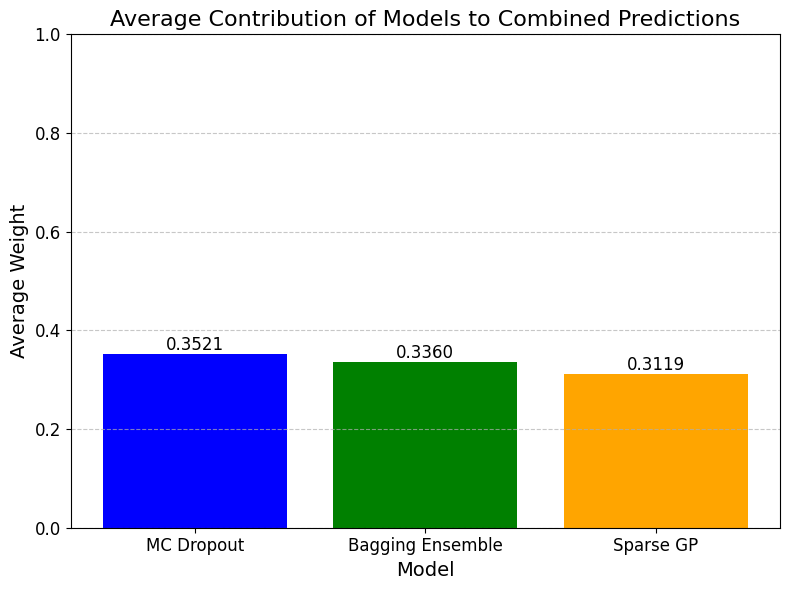

In [17]:
# Compute average contribution of each model across all predictions
average_weights = model_weights.mean(axis=0)

# Labels for the models
model_names = ['MC Dropout', 'Bagging Ensemble', 'Sparse GP']

# Plotting the contributions
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, average_weights, color=['blue', 'green', 'orange'])

# Add exact values above each bar
for bar, weight in zip(bars, average_weights):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{weight:.4f}', ha='center', va='bottom', fontsize=12)

plt.title('Average Contribution of Models to Combined Predictions', fontsize=16)
plt.ylabel('Average Weight', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)  # Weights are normalized, so they should sum to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the graph
plt.tight_layout()
plt.show()

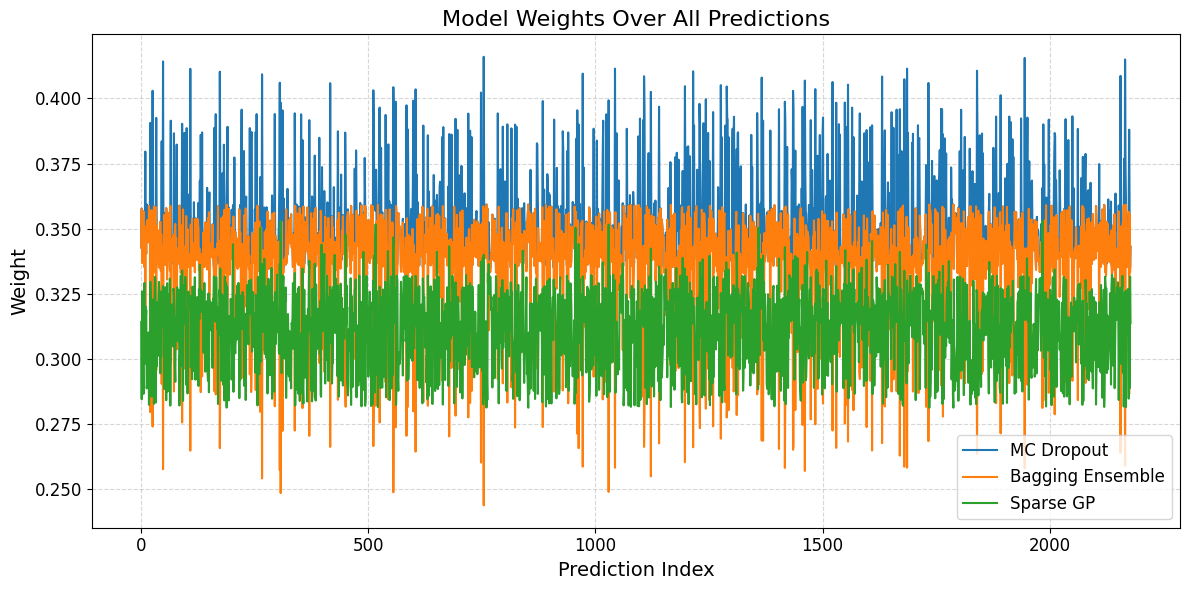

In [18]:
# Assume model_weights is a NumPy array of shape (num_samples, num_models)
# Rows correspond to test samples, columns correspond to model weights (MC Dropout, Bagging, Sparse GP)

# Labels for the models
model_names = ['MC Dropout', 'Bagging Ensemble', 'Sparse GP']

# Plotting weights for all predictions
plt.figure(figsize=(12, 6))

for i, model_name in enumerate(model_names):
    plt.plot(model_weights[:, i], label=model_name, linewidth=1.5)

plt.title('Model Weights Over All Predictions', fontsize=16)
plt.xlabel('Prediction Index', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.5, linestyle='--')
plt.tight_layout()

# Display the graph
plt.show()

Spread of Weights for Each Model:
              Model       Min       Max      Mean    Median       Std
0        MC Dropout  0.334589  0.416004  0.352136  0.348149  0.016205
1  Bagging Ensemble  0.243930  0.359320  0.336012  0.340971  0.021184
2         Sparse GP  0.281360  0.353019  0.311851  0.314378  0.015152


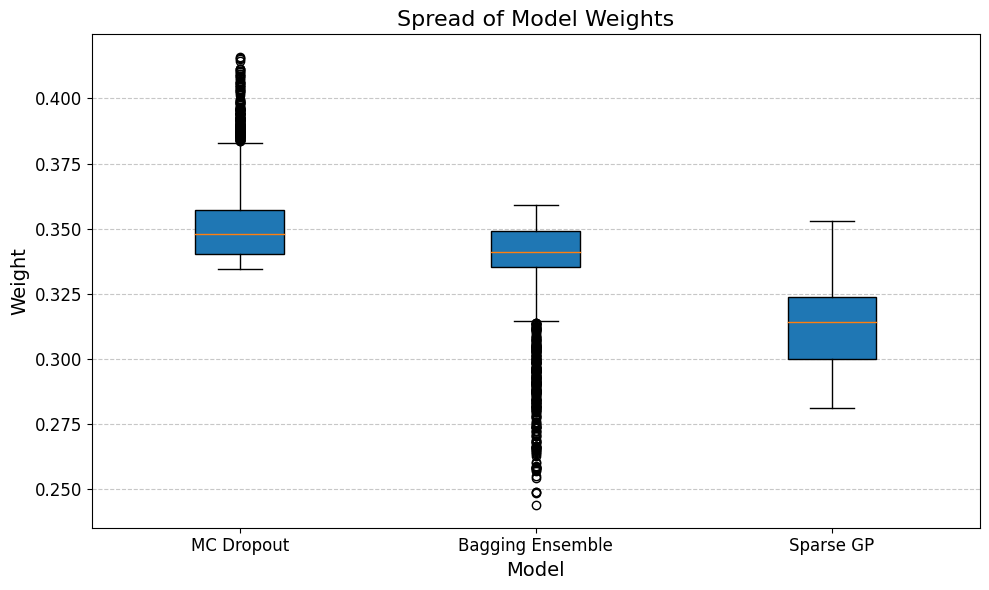

In [19]:
# Calculate statistics for each model's weights

# Create a DataFrame for better organization
weight_stats = {
    'Model': ['MC Dropout', 'Bagging Ensemble', 'Sparse GP'],
    'Min': model_weights.min(axis=0),
    'Max': model_weights.max(axis=0),
    'Mean': model_weights.mean(axis=0),
    'Median': np.median(model_weights, axis=0),
    'Std': model_weights.std(axis=0),
}

# Convert to DataFrame for display
weight_stats_df = pd.DataFrame(weight_stats)

# Display statistics
print("Spread of Weights for Each Model:")
print(weight_stats_df)

# Plot box plots for each model's weights
plt.figure(figsize=(10, 6))

# Pass model_weights (not transposed) to match labels
plt.boxplot(model_weights, labels=['MC Dropout', 'Bagging Ensemble', 'Sparse GP'], patch_artist=True)

plt.title('Spread of Model Weights', fontsize=16)
plt.ylabel('Weight', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


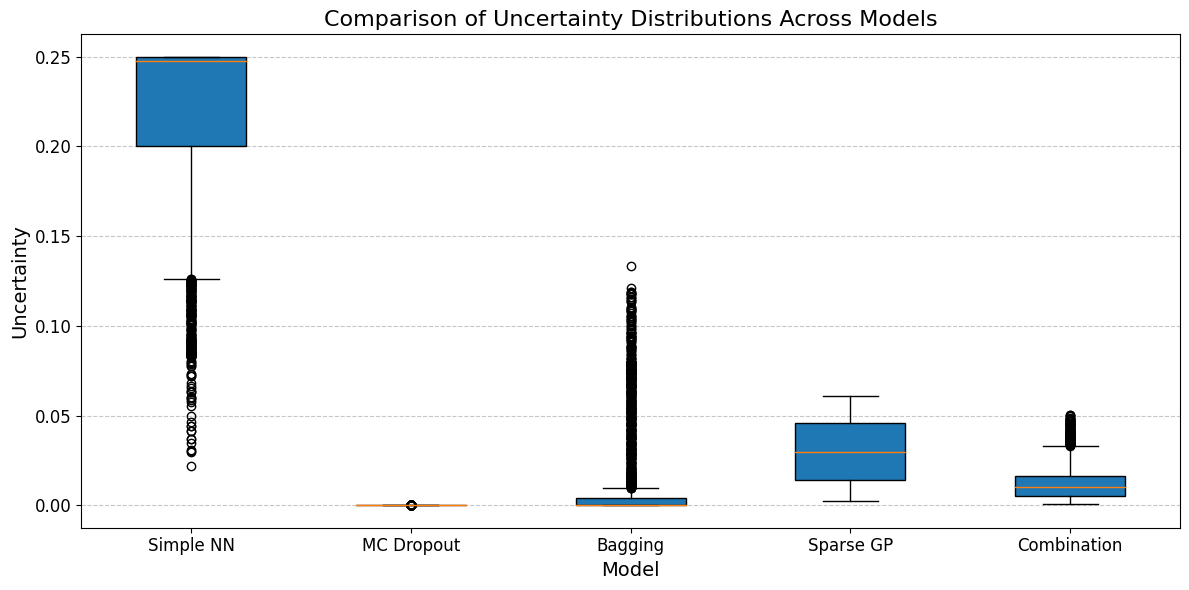

In [20]:
# Combine uncertainties into a single list for boxplot
all_uncertainties = [
    uncertainties_simpleNN,
    uncertainties_mc_dropout,
    uncertainties_bagging,
    uncertainties_sgp,
    all_combination_uncertainties
]

# Labels for the boxplots
model_labels = ['Simple NN', 'MC Dropout', 'Bagging', 'Sparse GP', 'Combination']

# Plot boxplots
plt.figure(figsize=(12, 6))
plt.boxplot(all_uncertainties, labels=model_labels, patch_artist=True)

plt.title('Comparison of Uncertainty Distributions Across Models', fontsize=16)
plt.ylabel('Uncertainty', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Display the plot
plt.show()


In [21]:

# Data for the table
model_names = ['Simple NN', 'MC Dropout', 'Bagging', 'Sparse GP', 'Combination']
accuracies = [
    accuracy_NN,
    accuracy_MC,
    accuracy_Bag,
    accuracy_SGP,
    accuracy_Combine
]
times_exceeding_125ms = [
    times_exceeding_125ms_NN,
    times_exceeding_125ms_MC,
    times_exceeding_125ms_Bag,
    times_exceeding_125ms_SGP,
    times_exceeding_125ms_Combine
]
average_times = [
    average_time_per_prediction_NN,
    average_time_per_prediction_MC,
    average_time_per_prediction_Bag,
    average_time_per_prediction_SGP,
    average_time_per_prediction_Combine
]
# Calculate average uncertainties
average_uncertainties = [
    np.mean(uncertainties_simpleNN),
    np.mean(uncertainties_mc_dropout),
    np.mean(uncertainties_bagging),
    np.mean(uncertainties_sgp),
    np.mean(all_combination_uncertainties)
]

# Create a DataFrame
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Times >125ms': times_exceeding_125ms,
    'Avg Time (ms)': average_times,
    'Avg Uncertainty': average_uncertainties
})

# Print for reference in the notebook
print(comparison_table)

         Model  Accuracy  Times >125ms  Avg Time (ms)  Avg Uncertainty
0    Simple NN  0.877926             0       0.112601     2.168329e-01
1   MC Dropout  0.877926             0       3.229353     3.200602e-14
2      Bagging  0.893529             0       0.380380     1.200554e-02
3    Sparse GP  0.726480             0       1.662631     3.041790e-02
4  Combination  0.886186             0       5.570166     1.279799e-02
